In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import  kstest
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

## Датасет

https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset - набор данных о коронавирусе

## Первичный анализ   и предобработка данных

#### Постановка задачи.

Данная работа будет посвящена исследованию поведения коронавируса в восточных странах. Основными целями является изучение длительности инкубационного периода в Китае и в остальных странах востока, а также построение временного ряда, предсказывающего количество новых случаев заболевания.

In [2]:
data = pd.read_csv("COVID19_line_list_data.csv")
data.head()

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,First confirmed imported cases in Zhejiang: pa...,Zhejiang,China,male,46.0,01/04/20,...,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,female,60.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,male,58.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   Unnamed: 3             0 non-null      float64
 4   summary                1080 non-null   object 
 5   location               1085 non-null   object 
 6   country                1085 non-null   object 
 7   gender                 902 non-null    object 
 8   age                    843 non-null    float64
 9   symptom_onset          563 non-null    object 
 10  If_onset_approximated  560 non-null    float64
 11  hosp_visit_date        507 non-null    object 
 12  exposure_start         128 non-null    object 
 13  exposure_end           341 non-null    object 
 14  visiting Wuhan         1085 non-null   int64  
 15  from

Колонки Unnamed, Id явно никакой информации не несут - избавимся от них.

In [4]:
data.drop(['Unnamed: 3', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 
           'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'id'],
          axis = 1, inplace =True)

Источник и ссылка нам не понядобятся в нашем исследовании. Источник не так важен так как данные о месте содержатся в других колонках. Также выбросим описание - возможно там есть интересная информация, но, обработка текста - весьма нетривиальная задача, достойная отдельного проекта. 

In [5]:
data.drop(['link', 'source', 'summary'], axis = 1, inplace = True)

Полю if_onset_approximated я не смог найти логического объяснения, поэтому также убираем его

In [6]:
data.drop(['If_onset_approximated'], axis = 1, inplace = True)

Выбросим также другие колонки, отвечающие за признаки, не несущие информации для данного исследования. 

gender - пол,  

visiting Wuhan - индикатор, посещал ли человек Ухань

колока age - возраст,  

from Wuhan - индикатор, является ли человек жителем Ухани

death - индикатор, умер ли зараженный, 

recovered - индикатор, выздоровел ли зараженный

reporting date - когда стало известно о случае заражения

case_in_country - какой по счету случай заражения в стране

location - место инфицирования в стране

hosp_visit_date - дата посещения зараженным больницы

In [7]:
data.drop(['gender', 'age', 'visiting Wuhan', 'from Wuhan', 'death', 'recovered', 
          'reporting date', 'case_in_country', 'location', 'hosp_visit_date'], axis = 1, inplace = True)

In [8]:
data.head()

,country,symptom_onset,exposure_start,exposure_end,symptom
0,China,01/03/20,12/29/2019,01/04/20,NaN
1,China,1/15/2020,NaN,01/12/20,NaN
2,China,01/04/20,NaN,01/03/20,NaN
3,China,NaN,NaN,NaN,NaN
4,China,NaN,NaN,NaN,NaN


country - страна

symptom_onset - дата проявления первых симптомов

exposure_start - дата начала контакта человека с инфицированным

exposure_end - дата конца контакта человека с инфицированным

symptom - симптомы

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   country         1085 non-null   object
 1   symptom_onset   563 non-null    object
 2   exposure_start  128 non-null    object
 3   exposure_end    341 non-null    object
 4   symptom         270 non-null    object
dtypes: object(5)
memory usage: 42.5+ KB


###### Посчитаем инкубационный период

In [10]:
from datetime import datetime

def to_date(date):
    if len(date.split('/')[-1])==2:
        return datetime.strptime(date, '%m/%d/%y').date()
    return datetime.strptime(date, '%m/%d/%Y').date()

def numOfDays(date1, date2): 
    return (to_date(date2)-to_date(date1)).days 

def IncubationPeriod(row, m):
    if type(row['exposure_end']) == str and type(row['symptom_onset']) == str:
        nD = numOfDays(row['exposure_end'], row['symptom_onset'])
        if nD >= 0:
            return nD + m
    elif type(row['exposure_start']) == str  and type(row['symptom_onset']) == str:
        return numOfDays(row['exposure_start'], row['symptom_onset']) - m
    return None

def CalculateIncubationPeriod(data):
    deltaDays = np.array(
        [numOfDays(row['exposure_start'], row['exposure_end']) 
                     for row in data.iloc
                     if type(row['exposure_start']) == str 
                     and type(row['exposure_end']) == str ])
    median = np.median(deltaDays)
    return np.array([IncubationPeriod(row, median) for row in data.iloc])

data['incubation_period'] = CalculateIncubationPeriod(data)

##### Выделим восточные страны

In [11]:
east = ['Afghanistan', 'Australia', 'Cambodia', 'China', 
        'Hong Kong', 'India', 'Japan', 'Malaysia',
       'Nepal', 'Phillipines', 'Singapore', 'South Korea', 
        'Sri Lanka', 'Taiwan', 'Thailand', 'Vietnam', 'Bahrain', 
        'Iran', 'Israel', 'Kuwait', 'Lebanon', 'UAE']
east_data = data[data['country'].isin(east)]

In [12]:
IncubationOther = east_data[(east_data['country'] != 'China') & (east_data['country'] != 'Hong Kong')]['incubation_period'].dropna().values.astype(float)
IncubationChina = east_data[(east_data['country'] == 'China') | (east_data['country'] == 'Hong Kong')]['incubation_period'].dropna().values.astype(float)

In [13]:
def parse(element):
    bad = "\\,"
    for c in bad:
        element = element.replace(c, "")
    return element

def plot_symptoms(data_symptom, ax):
    temp = [a.split(' ') for a in data_symptom]
    unique_symptoms = dict()
    total_count = data_symptom.shape[0]
    for element  in temp:
        for symptom in element:
            if parse(symptom) not in unique_symptoms:
                unique_symptoms[parse(symptom)] = 0
            else:
                unique_symptoms[parse(symptom)] += 1
    symptoms = []
    counts = []
    for symptom in unique_symptoms:
        if unique_symptoms[symptom] > total_count / 20:
            symptoms.append(symptom)
            counts.append(unique_symptoms[symptom])
    ax.bar(symptoms, counts)
    plt.show()

####  Выделим информацию, необходимую для временного ряда

In [14]:
data_series = pd.read_csv("time_series_covid_19_confirmed.csv")
data_series = data_series.fillna('unknow')
data_series = data_series[data_series['Country/Region'].isin(east)]
data_series = data_series.append(data_series.sum(numeric_only=True), ignore_index=True)
data_series = data_series.iloc[- 1][4:data_series.shape[1]]
for i in reversed(range(1, data_series.shape[0])):
    data_series[i] -= data_series[i - 1]

In [15]:
data_series_train = data_series[223:284]
data_series_test = data_series[284:]

### Визуальный анализ данных

Посмотрим на гистограмму симптомов, чтобы иметь некоторое представление о том, какие из них все же встречаются чаще.

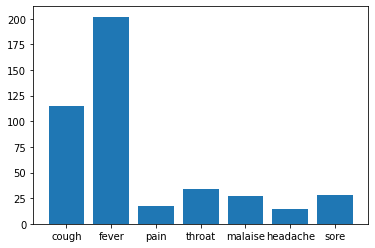

In [16]:
ax = plt.subplot()
plot_symptoms(data['symptom'].dropna(), ax, )

Таким образом, судя по нашей выборке, основными симптомами заболевания являются температуру, кашель, боль в горле,  общие недомогания. Остальные симптомы встречаются у менее чем 5 % выборки.

Построим гистограммы распределений инкубационного периода в Китае и остальных странах Азии.

In [17]:
def plot_distr(gen_pop):
    x = np.linspace(gen_pop.min(), gen_pop.max(), 100)
    mean = gen_pop.mean()
    std = gen_pop.std()
    theta = std / mean
    k = mean / theta
    y_pdf = stats.chi2.pdf(x, mean)
    y_cdf = stats.chi2.cdf(x, mean)

    ax1 = plt.subplot(121)
    plt.hist(gen_pop, 30, alpha=0.5)
    plt.twinx()
    plt.plot(x, y_pdf, label='pdf', color = 'b')
    plt.legend()

    ax2 = plt.subplot(122)
    plt.plot(x, y_cdf, label='cdf', color = 'r')
    plt.twinx()
    plt.plot(x, y_pdf, label='pdf', color = 'b')
    plt.legend()

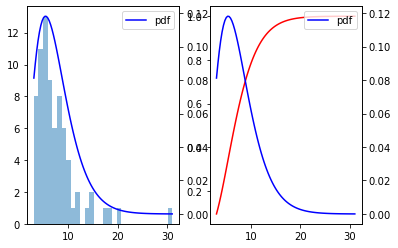

In [18]:
plot_distr(IncubationOther)

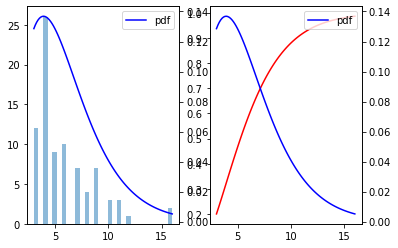

In [19]:
plot_distr(IncubationChina)

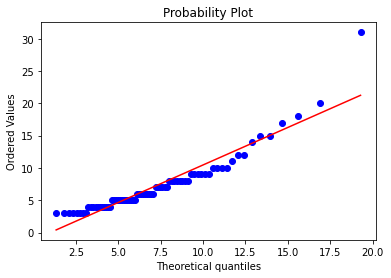

In [20]:
stats.probplot(IncubationOther, dist = stats.chi2(np.mean(IncubationOther)), plot = plt)
plt.show()

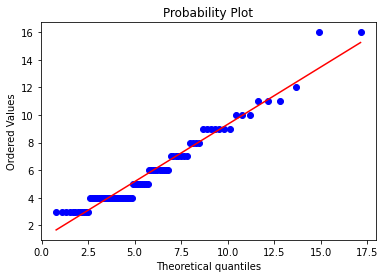

In [21]:
stats.probplot(IncubationChina, dist = stats.chi2(np.mean(IncubationChina)), plot = plt)
plt.show()

Одно из них похоже на хи-квадрат, второе не очень. Однако, соответствующие гипотезы надо проверить, также это наталкивает на мысль, что инкубационные периоды не являются одинаковыми для всех стран.

### Проверка статистических гипотез

##### Гипотеза 1: 
выборка, состоящая из интересующих нас инкубационных периодов является нормальной (скорее всего нет, но на всякий случай проверим это)

H0: выборка является нормальной.

H1: выборка не является нормальной.

p-value: 0.05

In [22]:
stats.shapiro(IncubationOther)

ShapiroResult(statistic=0.7643207311630249, pvalue=1.2484420164327048e-09)

H0: выборка является нормальной.

H1: выборка не является нормальной.

p-value: 0.05

In [23]:
stats.shapiro(IncubationChina)

ShapiroResult(statistic=0.8424878120422363, pvalue=5.2291856178499074e-08)

#### Вывод:
Таким образом, наши выборки не являются нормальными, впрочем это было вполне себе ожидаемо.

#### Гипотеза 2:
выборка принаделжит распределению хи-квадрат или гамма распределнию с соответствующими параметрами

H0: выборка принаделжит распределению хи-квадрат.

H1: выборка не принаделжит распределению хи-квадрат.

p-value: 0.05

In [24]:
kstest(IncubationOther, 'gamma', args=(np.mean(IncubationOther)/2, 0, 2))

KstestResult(statistic=0.12652374804328032, pvalue=0.16617866548217938)

H0: выборка принаделжит распределению хи-квадрат.

H1: выборка не принаделжит распределению хи-квадрат.

p-value: 0.05

In [25]:
kstest(IncubationChina, 'gamma', args=(np.mean(IncubationChina)/2, 0, 2))

KstestResult(statistic=0.20004837104606782, pvalue=0.0020135126316239258)

#### Вывод:

Выходит, одна из выборок принадлежит распределению хи-квадрат, а вторая нет, что наталкивает на мысль, что выборки взяты из различных распределний.

#### Гипотеза 3:
Выборки принадлажат одному распределению (убедимся навярянка что это не так)

H0: выборки принаделжат одному распределению.

H1: выборки принаделжат одному распределению.

p-value: 0.05

In [26]:
stats.ranksums(IncubationOther, IncubationChina)

RanksumsResult(statistic=2.2220111010823804, pvalue=0.026282555391118637)

на самом деле p_value хоть и меньше 0.05 но не самый маленький, проверим равенство средних выборок.

In [27]:
delta  = (np.mean(IncubationOther) - np.mean(IncubationChina)) / (np.std(IncubationOther) ** 2 / IncubationOther.shape[0]+ np.std(IncubationChina) ** 2 / IncubationChina.shape[0])
print(delta)

3.9248655638254646


Данная статистика асимпототически принадлежит стандартному нормальному распределению, значит должна попадать в доверительный интервал. Данное значение не входит в его доверительный интервал, значит можем еще более увренно отвергнуть гипотезу о равенстве средних, а значит и о однородности выборок

### 5. Предсказание временного ряда.

In [28]:
def arima_model(X, p, d, q):
    X = X.astype('float32')
    size = len(X) // 2
    train, test = X[0:size], X[size:]
    train = train.tolist()
    predictions = list()
    for t in range(test.shape[0]):
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit(disp=0)
        predictions.append(model_fit.forecast()[0])
        train.append(test[t])
    return sqrt(mean_squared_error(test, predictions))

def chose_model(data, p_values, d_values, q_values):
    data = data.astype('float32')
    rmse_res = np.inf
    p_res = 0
    d_res = 0
    q_res = 0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    rmse = arima_model(data, p, d, q)
                    if rmse < rmse_res:
                        rmse_res = rmse
                        p_res = p
                        d_res = d
                        q_res = q
                    print('RMSE = ', rmse , ' q =', q, ' d =', d, ' p =', p)
                except:
                    print('bad config: q= ', q, ' d =', d, ' p =', p)
                    continue
    print('BEST RMSE = ', rmse_res , ' q =', q_res, ' d =', d_res, ' p =', p_res)

In [29]:
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
chose_model(data_series_train.values, p_values, d_values, q_values)

RMSE =  20923.08957391522  q = 0  d = 0  p = 0
RMSE =  12472.187817577673  q = 1  d = 0  p = 0
RMSE =  9857.17280485981  q = 2  d = 0  p = 0
RMSE =  9759.02971498075  q = 3  d = 0  p = 0
RMSE =  8500.506566610826  q = 4  d = 0  p = 0
RMSE =  6197.945044591399  q = 0  d = 1  p = 0
RMSE =  6384.303185465183  q = 1  d = 1  p = 0
RMSE =  5904.0318083929  q = 2  d = 1  p = 0
RMSE =  6094.655822656478  q = 3  d = 1  p = 0
bad config: q=  4  d = 1  p = 0
RMSE =  8855.911614062294  q = 0  d = 2  p = 0
bad config: q=  1  d = 2  p = 0
bad config: q=  2  d = 2  p = 0
RMSE =  6047.182517785094  q = 3  d = 2  p = 0
RMSE =  5881.652720140524  q = 4  d = 2  p = 0
bad config: q=  0  d = 3  p = 0
bad config: q=  1  d = 3  p = 0
bad config: q=  2  d = 3  p = 0
bad config: q=  3  d = 3  p = 0
bad config: q=  4  d = 3  p = 0
bad config: q=  0  d = 4  p = 0
bad config: q=  1  d = 4  p = 0
bad config: q=  2  d = 4  p = 0
bad config: q=  3  d = 4  p = 0
bad config: q=  4  d = 4  p = 0
RMSE =  7173.9705517390

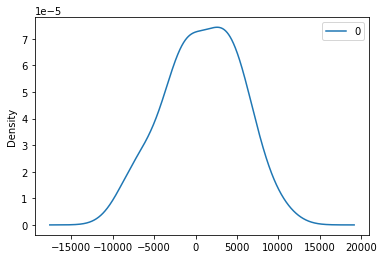

Result RMSE:  4491.9873426690965


In [30]:
train, test = data_series_train.values, data_series_test.values
predictions = list()
train = data_series_train.tolist()
for i in range(test.shape[0]):
    model = ARIMA(train, order=(4, 1, 1))
    model_fit = model.fit(disp=0)
    predictions.append(model_fit.forecast()[0])
    train.append(test[i])
errors = pd.DataFrame([test[i]-predictions[i] for i in range(test.shape[0])])
errors.plot(kind='kde', ax=plt.gca())
plt.show()
print('Result RMSE: ', sqrt(mean_squared_error(test, predictions)))

## Вывод

1. В небольшой гистограмме симптомов ничего удивительного обнаружено не было - самыми популярными как и ожидалсь являюстя температура, кашель, боль в горле и общее недомогание.

2. С инкубационным периодом дело обстоит интереснее. Изначально мне казалось, что у болезни должен быть один и тот же, независимо от страны. Однако, исследование показало другой результат, в Китае и в остальных восточных странах инкубационные периоды имеют разные распределения. Выходит, необходимо, с большой осторожностью относится к данным об инкубационных периодах - ведь, как показало исследование, они могут быть разными.

3. Распределение инкубационного периода остальных восточных стран - хи-квадрат

4. Построен временной ряд, предсказывающий количество новых инфицированных пациентов в день.